In [ ]:
# torchtext.legacy를 사용하기 위하여 아래 torchtext의 0.10.0 version을 설치한다
!pip install torchtext==0.10.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 7.6 MB 20.2 MB/s 
     |████████████████████████████████| 831.4 MB 2.8 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.13.1
    Uninstalling torchtext-0.13.1:
      Successfully uninstalled torchtext-0.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.13.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.
torchaudio 0.12.1+cu113 requires torch==1.12.1, but you have torch 1.9.0 which is incompatible.


In [ ]:
# 필요한 Module을 import한다
# 아래를 시작하기 위하여 kernel을 restart해야한다
import torch
import torch.nn as nn
import torch.optim as optim

# torchtext는 텍스트에 대한 여러 추상화 기능을 제공하는 모듈이다
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import spacy
import numpy as np

import random
import math
import time

Dataset은 PyTorch에서 제공하는 Multi30k dataset을 사용할 계획이다. 

In [ ]:
# 문장을 Tokenize하는 module을 설치한다
!python -m spacy download en_core_web_sm # 영어 문장 Tokenize용
!python -m spacy download de_core_news_sm # 독일어 문장 Tokenize용

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.8 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.6 MB 469 kB/s 
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [ ]:
# Tokenize Module import하기
import de_core_news_sm
import en_core_web_sm

spacy_en = en_core_web_sm.load() # English Sentence Tokenize
spacy_de = de_core_news_sm.load() # Destuch Sentence Tokenize


# 독일어 문장을 입력받아 Tokenize한다
# 논문에서는 입력문장을 Reverse order로 재 정렬하여 삽입하는데 이 효과로 text perplexity를 5.8에서 4.7로 감소시킨다
def tokenize_de(text):
  return [tok.text for tok in spacy_de.tokenizer(text)][::-1]

# 영어 문장을 입력받아 Tokenize한다
def tokenize_en(text):
  return [tok.text for tok in spacy_en.tokenizer(text)]


# Field는 torchvision의 transforms.Compose와 같이
# 데이터를 어떻게 처리하여 불러올 지 조절하는 메소드이다
# 전처리 함수라고 볼 수 있다

# source 데이터를 전처리할 때 사용하는 함수 정의
SRC = Field(tokenize = tokenize_de,
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True
            )
# target 데이터를 전처리할 때 사용하는 함수 정의
TRG = Field(tokenize = tokenize_en,
            init_token = "<sos>",
            eos_token = "<eos>",
            lower = True
            )

In [ ]:
# Dataset 불러오기
# Multi 30K dataset을 이용하여 30000개의 영어, 독일어 문장을 다음과 같이 불러온다
# exts : 확장자 (영어, 독일어 파일)
# fields : 전처리 객체
# 그리하여 SRC에는 독일어 문장, TRG에는 영어문장이 로드된다

train_data, valid_data, test_data = Multi30k.splits(exts=('.de','.en'), fields=(SRC, TRG))

downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:03<00:00, 394kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 116kB/s] 


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 109kB/s]


In [ ]:
print("Number of training examples : {}".format(len(train_data.examples)))
print("Number of validation examples : {}".format(len(valid_data.examples)))
print("Number of test examples : {}".format(len(test_data.examples)))

Number of training examples : 29000
Number of validation examples : 1014
Number of test examples : 1000


In [ ]:
# build Vocabulary Dictionary
# 정의한 필드에 .build_vocab() 도구를 사용하면 단어 집합을 생성한다

# min_freq=2 : 2회 이상 등장한 단어만을 단어사전에 등재시키겠다는 의미이다
# 1번 이하 등장한 단어는 <unk>로 대체한다
SRC.build_vocab(train_data, min_freq=2)
TRG.build_vocab(train_data, min_freq=2)

In [ ]:
# pytorch device 정의하기
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# batch_size 정의하기
batch_size = 128

# Bucket Iterator 모듈을 이용하면 다음과 같이 data를 batch개수만큼 불러오는 Dataloader와 비슷한
# Iterator를 정의할 수 있다
train_iterator, valid_iterator, test_iterator = BucketIterator.splits((train_data, valid_data, test_data), batch_size=batch_size, device=device)

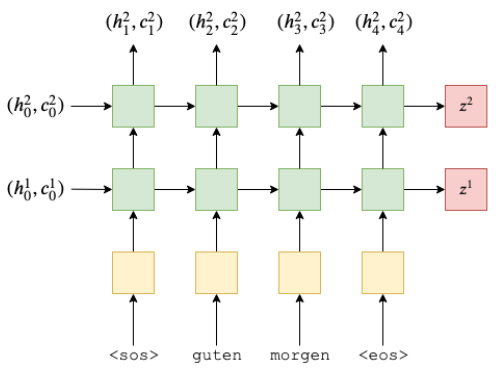

In [ ]:
# Encoder
class Encoder(nn.Module):
  def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    # input되는 단어들은 모두 one_hot_vector로 이루어져 있다

    # input_dim : input data의 vocab_size = one-hot vector크기
    # embed_dim : 각각의 단어의 one-hot vector를 emb_dim길이의 dense_vector로 변환하는 것이다
    # hid_dim : hidden_state의 차원 (=cell state의 차원)
    # n_layers : LSTM을 몇 층으로 쌓아올릴 것인가
    # n_direction : 1 (단방향 LSTM 이므로)

    self.hid_dim = hid_dim
    self.n_layers = n_layers

    # 단어는 모두 one_hot vector의 Index로 이루어져 있다.
    # 이를 embbedding Vector로 변환하는 계층이다
    self.embedding = nn.Embedding(input_dim, emb_dim)

    # Embedding Vector를 입력받아 hid_dim 크기의 hidden State와 Cell state출력하는 LSTM정의
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    self.dropout = nn.Dropout(dropout)


  # input sequence를 입력받고 Decoder에 입력될 hidden state와 cell state를 출력한다
  def forward(self, src):
    # source의 shape : (src_len, Batch_size)

    # embedded된 단어 벡터
    # (src len, batch size, emb dim)
    embedded = self.dropout(self.embedding(src))

    # outputs : (src_len, batch_size, hid_dim * n_directions), encoder에서 출력되는 각 time_step마다의 hidden_state값들
    # hidden : (n_layers * n_direction, batch_size, hid_dim),각 layer의 마지막 은닉 상태
    # cell : (n_layers * n_direction, batch_size, hid_dim),각 layer의 마지막 셀 상태
    outputs, (hidden, cell) = self.rnn(embedded)


    return hidden, cell # 이 hidden과 cell state가 다음 decoder로 넘어간다

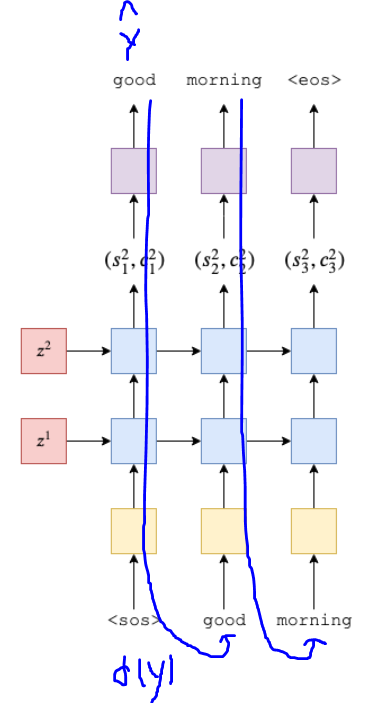

In [ ]:
# Decoder
class Decoder(nn.Module):
  def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
    super().__init__()

    self.output_dim = output_dim # output vector의 Vocab_size
    self.hid_dim = hid_dim
    self.n_layers = n_layers

    # 목적어의 단어를 입력받아 embbedding vector로 변환한다
    self.embedding = nn.Embedding(output_dim, emb_dim)

    # embbedd된 단어벡터를 입력받아 hidden_state와 cell_state를 출력해주는 LSTM정의
    self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout=dropout)

    # 각 hidden_state를 입력받아 output_dim 차원의 벡터를 반환한다
    # 즉, 해당 time step의 예상 출력 단어가 무엇인지 그 확률값을 반환하는 것이다
    self.fc_out = nn.Linear(hid_dim, output_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, input, hidden, cell):
    # input : (batch_size), Decoder의 첫 LSTM입력은 <SOS>이다 
    # hidden : (n_layers * n_direction, batch_size, hid_dim), Encoder의 마지막 LSTM에서 나온 hidden state를 각 대응하는 layer에 입력 한다
    # cell : (n_layers * n_direction, batch_size, hid_dim), Encoder의 마지막 LSTM에서 나온 cell state를 각 대응하는 layer에 입력 한다

    input = input.unsqueeze(0) # (1, batch_size)만큼의 <SOS> 입력
    
    embedded = self.dropout(self.embedding(input)) # (1, batch_size, emb_dim)

    output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
    # output: [seq len, batch_size, hid dim * n directions]
    # hidden: [n layers * n directions, batch size, hid dim]
    # cell: [n layers * n directions, batch size, hid dim]    

    prediction = self.fc_out(output.squeeze(0)) # (batch_size, output_dim)

    return prediction, hidden, cell

Teacher Forcing은 논문에서는 다루지 않지만, 기타 블로그의 구현 코드에서 다루고 있어 포함하였다. **이는 일정 확률로 Decoder의 t 시점 LSTM에 t-1시점의 예측단어를 입력하는 것이 아니라, target단어를 입력하는 것이다**.(원래 해당 자리에 와야 하는 단어).

 이렇게 되면 학습 초기에 안정적이다. 왜냐하면, **학습 초기에는 틀린단어를 예측할 확률이 높은데**, 틀린 단어를 다음 시점에 입력하기 보다, 이를 교정하여 올바른 단어를 LSTM Cell에 입력해주는 것으로, 학습 초기 안정적인 학습을 기대할 수 있다

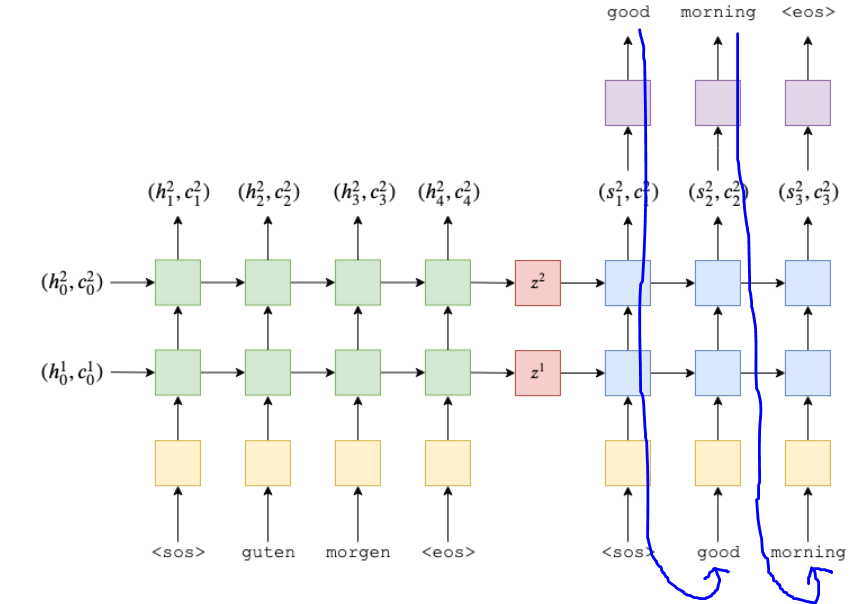

In [ ]:
# seq2seq
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

    # encoder와 decoder의 hid_dim일 일치하지 않는 경우 Error를 발생시킨다
    assert encoder.hid_dim == decoder.hid_dim, \
      "Hidden dimensions of encoder decoder must be equal"

    # encoder와 decoder의 layer개수가 일치하지 않는 경우 Error를 발생
    assert encoder.n_layers == decoder.n_layers, \
      "Encoder and Decoder must have equal number of layers" 

  def forward(self, src, trg, teacher_forcing_ratio = 0.5):
    # src : (src_len, batch_size)
    # trg : (trg_len, batch_size)

    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim # output vector의 Vocab_size   

    # decoder의 output을 저장하기 위한 Tensor정의
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    # Initial hidden/cell state : Encoder로부터 반환된 hidden_state, cell_state
    hidden, cell = self.encoder(src)

    # 첫 번째 입력인 <sos> Token
    input = trg[0,:]

    # <eos>제외하고 trg_len-1만큼 반복한다
    for t in range(1, trg_len):

      # t 시점에서의 decoder의 출력, hidden state, cell state이다
      output, hidden, cell = self.decoder(input, hidden, cell)

      # t 시점의 output을 저장한다
      outputs[t] = output

      # teacher forcing을 사용할지 말지 결정한다
      teacher_force = random.random() < teacher_forcing_ratio

      # 가장 높은 확률을 가진 값을 얻는다 = 예측된 단어이다
      top1 = output.argmax(1)
      
      # teacher forcing의 경우 다음 lstm에 target_token입력
      # teacher forcing이 아닌 경우 lstm에 prediction 입력
      input = trg[t] if teacher_force else top1

    return outputs

In [ ]:
# 하이퍼 파라미터 설정

# english, destuch의 vocabulary개수
# 총 단어에서 2회 이상 등장한 단어들 + 특수 용도로 사용되는 단어들만 단어사전에 담긴다
input_dim = len(SRC.vocab)
output_dim = len(TRG.vocab)

# 단어의 Embedding Vector의 차원
enc_emb_dim = 256
dec_emb_dim = 256

# Hidden_state 및 Cell State의 차원
hid_dim = 512

# layer개수
n_layers = 2

# Encoder / Decoder에 적용할 Dropout
enc_dropout = 0.5
dec_dropout = 0.5

In [ ]:
# model을 생성한다
enc = Encoder(input_dim, enc_emb_dim, hid_dim, n_layers, enc_dropout)
dec = Decoder(output_dim, dec_emb_dim, hid_dim, n_layers, dec_dropout)

model = Seq2Seq(enc, dec, device).to(device)

In [ ]:
# 가중치 초기화 함수
def init_weights(model):
  for name, param in model.named_parameters():
    nn.init.uniform_(param.data, -0.08, 0.08) # -0.08에서 0.08사이의 uniform distribution

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(7853, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(5893, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=5893, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
# 모델의 학습 가능한 파라미터의 수를 측정한다
# model.parameters() 호출 결과, model의 각 layer의 learnable parameter Tensor가 반환되고
# p.numel()은 해당 Tensor의 원소 개수를 count해준다

def count_parameters(model):
  return sum(p.numel() for p in model.paramters() if p.requires_grad)

In [ ]:
# optimizer 설정
optimizer = optim.Adam(model.parameters())

# Loss function 정의하기
# pad token : 모든 Dataset의 문장의 길이를 통일하기 위하여 
# 짧은 문장의 앞 또는 뒤에 padding을 추가하여 동일한 길이로 만든다

trg_pad_idx = TRG.vocab.stoi[TRG.pad_token] # pad_token의 index 반환
criterion = nn.CrossEntropyLoss(ignore_index = trg_pad_idx) # pad에 해당하는 index의 차이는 학습에 반영하지 않는다

In [ ]:
# 학습을 위한 함수를 정의하기
# Epoch의 평균 손실함수값 반환
def train(model, iterator, optimizer, criterion, clip):
  model.train()
  epoch_loss = 0

  for i, batch in enumerate(iterator): # 1 epoch의 훈련
    src = batch.src # batch_size개수의 destuch문장
    trg = batch.trg # batch_size개수의 english문장
    optimizer.zero_grad()

    # model에 src와 trg를 입력한다
    output = model(src, trg) # (trg_len, batch_size, output_dim)
    output_dim = output.shape[-1]
    output = output[1:].view(-1, output_dim) 
    # 첫 단어의 예측값은 당연히 같을 것이므로, 제외하여 output[1:]범위만 flatten한다
    # loss계산을 위하여 1차원으로 변경

    trg = trg[1:].view(-1) # loss 계산을 위해 1차원으로 변경
    # 첫 단어의 예측값은 당연히 같을 것이므로, 제외하여 trg[1:]범위만 flatten한다

    # 예측값 output과 정답 trg의 손실함수를 계산
    loss = criterion(output, trg) 
    loss.backward()

    # Gradient clipping 실시
    # Gradient Clipping은 Exploding Gradient의 대책 중 하나이다
    # model.parameters()에 저장되는 Gradient값이 clip이상이면 Gradient Cliping하여 기울기가 너무 커지지 않도록 한다
    # if ||g|| >= clip : 
    #     g = ( clip / ||g|| ) * g
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [ ]:
# evaluation 함수를 정의
# 1 epoch을 평가하고 그 결과인 평균손실함수 반환
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0

  with torch.no_grad():
    for i, batch in enumerate(iterator):
      src = batch.src
      trg = batch.trg

      # output : (trg_len, batch_size, output_dim)
      output = model(src, trg, 0) # Teacher forcing Off
      output_dim = output.shape[-1]
      
      # (trg_len-1) * batch_size, output_dim
      output = output[1:].view(-1, output_dim)

      # (trg_len-1) * batch_size, output_dim
      trg = trg[1:].view(-1)

      loss = criterion(output, trg)
      epoch_loss += loss.item()

  return epoch_loss / len(iterator)


In [ ]:
# Time을 측정하기 위한 함수 정의
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
# 학습 시작
num_epochs = 10
clip = 1

best_valid_loss = float('inf')

for epoch in range(num_epochs):
   
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, clip)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 37s
	Train Loss: 5.066 | Train PPL: 158.524
	 Val. Loss: 4.981 |  Val. PPL: 145.558
Epoch: 02 | Time: 0m 36s
	Train Loss: 4.491 | Train PPL:  89.202
	 Val. Loss: 4.702 |  Val. PPL: 110.150
Epoch: 03 | Time: 0m 37s
	Train Loss: 4.171 | Train PPL:  64.763
	 Val. Loss: 4.622 |  Val. PPL: 101.685
Epoch: 04 | Time: 0m 37s
	Train Loss: 3.982 | Train PPL:  53.635
	 Val. Loss: 4.467 |  Val. PPL:  87.104
Epoch: 05 | Time: 0m 37s
	Train Loss: 3.814 | Train PPL:  45.316
	 Val. Loss: 4.327 |  Val. PPL:  75.715
Epoch: 06 | Time: 0m 37s
	Train Loss: 3.651 | Train PPL:  38.503
	 Val. Loss: 4.286 |  Val. PPL:  72.670
Epoch: 07 | Time: 0m 37s
	Train Loss: 3.525 | Train PPL:  33.948
	 Val. Loss: 4.142 |  Val. PPL:  62.910
Epoch: 08 | Time: 0m 37s
	Train Loss: 3.365 | Train PPL:  28.942
	 Val. Loss: 4.100 |  Val. PPL:  60.319
Epoch: 09 | Time: 0m 36s
	Train Loss: 3.266 | Train PPL:  26.211
	 Val. Loss: 3.978 |  Val. PPL:  53.414
Epoch: 10 | Time: 0m 37s
	Train Loss: 3.147 | Train PPL

마지막으로 Test Data에 대한 성능 평가 시행

Perplexity는 Language Model을 평가하기 위한 지표로 **PPL**이라고도 한다. 쉽게 생각하면 "**헷갈리는 정도**"라고 볼 수 있으며, **낮을 수록 좋은 성능**이라는 의미이다

 다음에 나올 단어가 "say"인데, 모델이 다음 단어가 say일 확률을 0.8로 예측 했다고 해보자. 이 때 PPL값은 1 / 0.8 = 1.25가 된다.
즉 PPL은 **확률의 역수 값**이다.

 이 확률의 역수는 어떠한 의미로 해석이 될까? 이는 **number of Branches**라고 볼 수 있다. 다음에 나올 단어의 후보를 확신을 가지고 1개 정도로 좁혔다는 의미이다. 즉 PPL값은 **낮을 수록 좋은 성능**임을 나타낸다

In [ ]:
# best val loss일 때의 가중치를 불러온다
model.load_state_dict(torch.load('tut1-model.pt'))

# test loss를 측정한다
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 3.913 | Test PPL:  50.025 |
